In [10]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    "../../../gckey.json",
    [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive",
    ],
)
client = gspread.authorize(credentials)
spreadsheet = client.open("MaLA data mixing ablation")
Viking_7B_Flores_200_De_En_BLEU = spreadsheet.worksheet("Viking-7B-Flores-200-De-En-BLEU")

In [13]:
Viking_7B_Flores_200_De_En_BLEU_Data = Viking_7B_Flores_200_De_En_BLEU.get_all_records(value_render_option="UNFORMATTED_VALUE")
df = pd.DataFrame(Viking_7B_Flores_200_De_En_BLEU_Data, columns=Viking_7B_Flores_200_De_En_BLEU_Data[0])
df = df.replace('', np.nan)

/tmp/ipykernel_2988763/1709479095.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)


In [14]:
df

,Model,checkpoint-500,checkpoint-1000,checkpoint-1500,checkpoint-2000,checkpoint-2500,checkpoint-3000,checkpoint-3500,checkpoint-4000,checkpoint-4500
0,Viking-7B-Bilingual-Code-Selfish,0.181864,12.830001,8.999837,9.023091,9.337336,11.012691,5.485116,6.873853,10.512592
1,Viking-7B-Bilingual-Selfish,1.611070,0.914056,0.749163,1.918590,1.148719,1.147025,2.096166,2.275474,NaN
2,Viking-7B-Monolingual-Code-Selfish,19.018391,14.554164,18.613187,16.453737,16.143918,17.753162,19.197487,20.363053,NaN
3,Viking-7B-Monolingual-Selfish,20.364226,12.636016,16.079099,14.232441,15.261992,16.726859,15.891780,NaN,NaN


In [15]:
model_info = {
    "Viking-7B-Bilingual-Code-Selfish": {
        "final_ckpt": 4500,
        "total_tokens": 300e6,  # 300M
    },
    "Viking-7B-Monolingual-Code-Selfish": {
        "final_ckpt": 4000,
        "total_tokens": 300e6,  # 300M
    },
    "Viking-7B-Bilingual-Selfish": {
        "final_ckpt": 4000, 
        "total_tokens": 200e6   # 200M
    },  
    "Viking-7B-Monolingual-Selfish": {
        "final_ckpt": 3500,
        "total_tokens": 200e6,  # 200M
    },
}


def ckpt_to_tokens(model_name: str, ckpt: int) -> float:
    """
    Given model name and checkpoint numbers, return the corresponding number of trained tokens.
    """
    info = model_info[model_name]
    final_ckpt = info["final_ckpt"]
    total_tokens = info["total_tokens"]
    if ckpt > final_ckpt:
        ckpt = final_ckpt

    return ckpt * (total_tokens / final_ckpt)

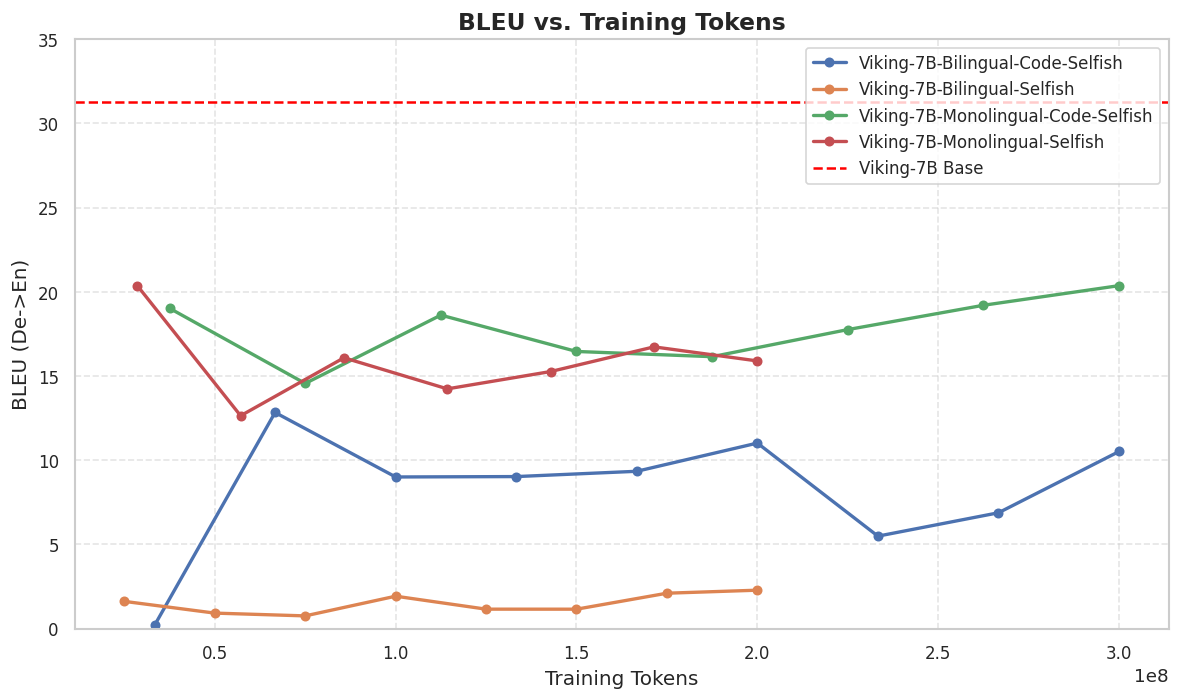

In [20]:
sns.set_theme(style="whitegrid")  

checkpoint_cols = [col for col in df.columns if col.startswith("checkpoint-")]

plt.figure(figsize=(10, 6), dpi=120)  

for i, row in df.iterrows():
    model_name = row["Model"]
    if model_name not in model_info:
        continue

    ckpt_bleu_pairs = []
    for col in checkpoint_cols:
        val = row[col]
        if pd.notna(val) and val != "":
            ckpt = int(col.split("-")[1])
            x_tokens = ckpt_to_tokens(model_name, ckpt)
            y_bleu = float(val)
            ckpt_bleu_pairs.append((x_tokens, y_bleu))

    ckpt_bleu_pairs.sort(key=lambda x: x[0])

    xs = [p[0] for p in ckpt_bleu_pairs]
    ys = [p[1] for p in ckpt_bleu_pairs]

    plt.plot(xs, ys,
             marker="o",
             linestyle="-",
             linewidth=2, 
             markersize=5, 
             label=model_name)
    
# Add horizontal dashed line for Viking-7B base score
viking_base_score = 31.29
plt.axhline(y=viking_base_score, color='red', linestyle='--', linewidth=1.5, label=f"Viking-7B Base")

plt.xlabel("Training Tokens", fontsize=12)
plt.ylabel("BLEU (De->En)", fontsize=12)
plt.ylim(0, 35)
plt.title("BLEU vs. Training Tokens", fontsize=14, fontweight="bold")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

plt.show()

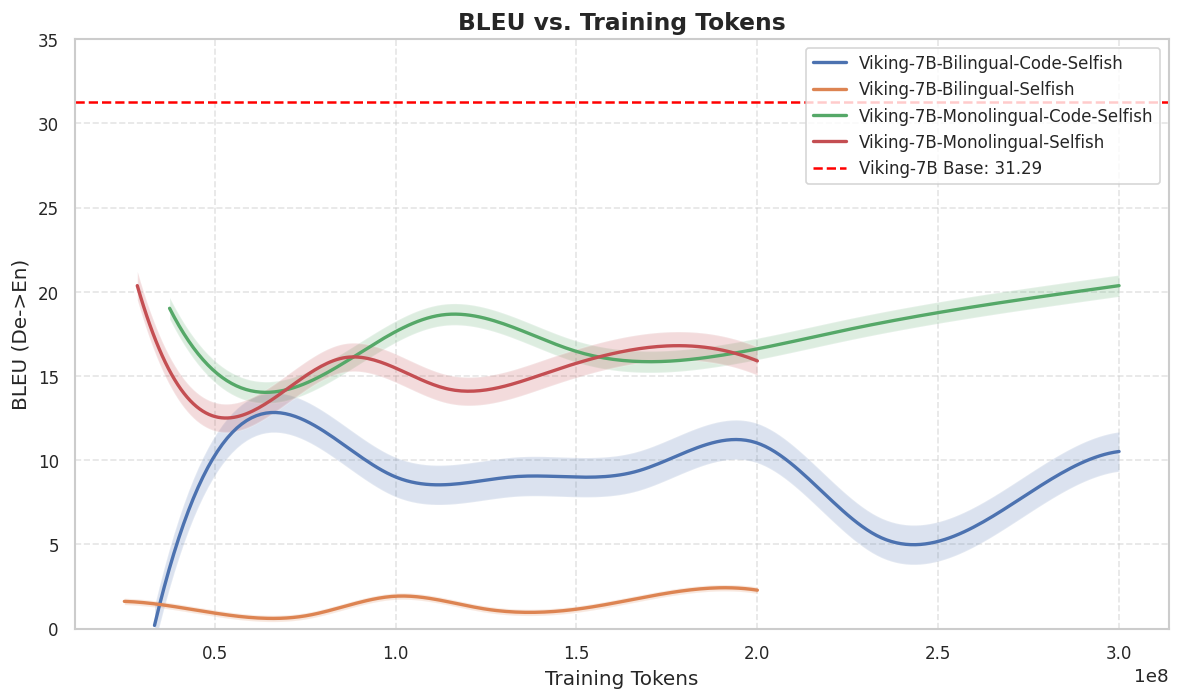

In [22]:
import numpy as np
from scipy.interpolate import make_interp_spline

sns.set_theme(style="whitegrid")

checkpoint_cols = [col for col in df.columns if col.startswith("checkpoint-")]

plt.figure(figsize=(10, 6), dpi=120)

for i, row in df.iterrows():
    model_name = row["Model"]
    if model_name not in model_info:
        continue

    ckpt_bleu_pairs = []
    for col in checkpoint_cols:
        val = row[col]
        if pd.notna(val) and val != "":
            ckpt = int(col.split("-")[1])
            x_tokens = ckpt_to_tokens(model_name, ckpt)
            y_bleu = float(val)
            ckpt_bleu_pairs.append((x_tokens, y_bleu))

    ckpt_bleu_pairs.sort(key=lambda x: x[0])

    xs = np.array([p[0] for p in ckpt_bleu_pairs])
    ys = np.array([p[1] for p in ckpt_bleu_pairs])

    # Smoothing the curve
    if len(xs) > 2:  # Ensure sufficient points for smoothing
        x_smooth = np.linspace(xs.min(), xs.max(), 200)
        spline = make_interp_spline(xs, ys, k=3)  # k=3 for cubic spline
        y_smooth = spline(x_smooth)

        # Calculate stderr (replace with actual stderr calculation if available)
        stderr = np.std(ys) / np.sqrt(len(ys))
        y_lower = y_smooth - stderr
        y_upper = y_smooth + stderr

        # Plot smooth curve and stderr
        plt.plot(x_smooth, y_smooth, label=model_name, linewidth=2)
        plt.fill_between(x_smooth, y_lower, y_upper, alpha=0.2)
    else:
        # Plot raw data if not enough points for smoothing
        plt.plot(xs, ys, marker="o", linestyle="-", linewidth=2, label=model_name)

# Add horizontal dashed line for Viking-7B base score
viking_base_score = 31.29
plt.axhline(y=viking_base_score, color='red', linestyle='--', linewidth=1.5, label=f"Viking-7B Base: {viking_base_score}")

plt.xlabel("Training Tokens", fontsize=12)
plt.ylabel("BLEU (De->En)", fontsize=12)
plt.ylim(0, 35)  # Adjusted ylim to include the Viking base score
plt.title("BLEU vs. Training Tokens", fontsize=14, fontweight="bold")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="best", fontsize=10)
plt.tight_layout()

plt.show()
